# Dimensionality Reduction
(using the titanic.csv dataset)

In [1]:
# IMPORTS

from fastai import *
from fastai.tabular import *

import numpy as np
import pandas as pd
import math
import random
import time
import statistics

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#GRAPHING FUNCTION

def cluster_scatter(x, colors):
    # choose a color palette with seaborn
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x.iloc[:,0], x.iloc[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x.iloc[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [4]:
# LOAD DATASET, PARSE

titanic = pd.read_csv('titanic-Copy1.csv')
survived = np.array(titanic['Survived'])
titanic = titanic[['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare']]

In [5]:
# MODIFY / NORMALIZE VALUES

def normalize(series):
    new_series = []
    for i in np.arange(len(series)):
        new_item = (series[i] - np.mean(series)) / np.std(series)
        new_series.append(new_item)
    return new_series

sexes = np.array(titanic['Sex'])
new_sex = []
for i in np.arange(len(sexes)):
    if sexes[i] == 'male':
        new_sex.append(0)
    else:
        new_sex.append(1)

new_age = normalize(titanic['Age'])
new_fare = normalize(titanic['Fare'])
new_sex = normalize(new_sex)

titanic['Pclass'] = normalize(titanic['Pclass'])
titanic['Siblings/Spouses Aboard'] = normalize(titanic['Siblings/Spouses Aboard'])
titanic['Parents/Children Aboard'] = normalize(titanic['Parents/Children Aboard'])

titanic['Sex'] = new_sex
titanic['Age'] = new_age
titanic['Fare'] = new_fare

In [6]:
# MAKE TRAIN / TEST SETS

xs = titanic.values
ys = survived

x_train = xs[0:750]
y_train = ys[0:750]

x_test = xs[750:]
y_test = ys[750:]

In [7]:
y_train.astype(np.int)

array([0, 1, 1, 1, ..., 1, 1, 0, 0])

In [8]:
# CHECK THAT DATAFRAME IS FINE

titanic.head(1)

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0.830524,-0.740266,-0.529366,0.429904,-0.474981,-0.503586


## PCA

In [9]:
# RUN PCA TRANSFORM

pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_train)

In [10]:
# MAKE PCA DATAFRAME

pca_df = pd.DataFrame(columns = ['pca1','pca2'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.7295450186312397, -0.39877729014378405, '0'),
  Text(0.3438936336794709, 0.04401189090042951, '1')])

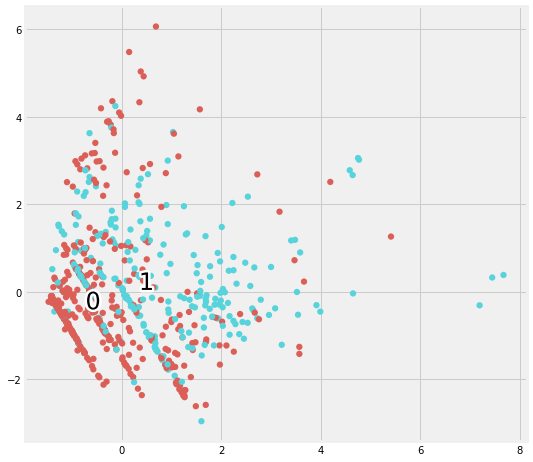

In [11]:
# PLOT PCA RESULTS

cluster_scatter(pca_df, y_train)

## T-SNE

In [12]:
# RUN TSNE TRANSFORM

tsne_result = TSNE().fit_transform(x_train)

In [13]:
# MAKE TSNE DATAFRAME

tsne_df = pd.DataFrame(columns = ['tsne1','tsne2'])

tsne_df['tsne1'] = tsne_result[:,0]
tsne_df['tsne2'] = tsne_result[:,1]

(<Figure size 576x576 with 1 Axes>,
 [Text(4.248042, -6.4537845, '0'), Text(-12.546427, 12.169055, '1')])

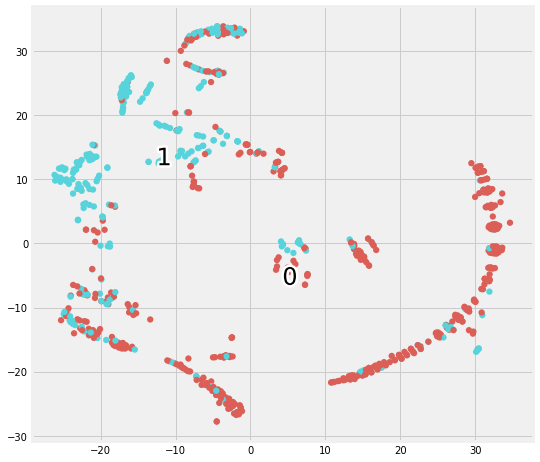

In [14]:
# PLOT TSNE RESULTS

cluster_scatter(tsne_df, y_train)

### Evaluating Classifiers:

In [15]:
# DISTANCE METRIC

def hamming_distance(s1,s2):
    assert len(s1) == len(s2)
    distance = 0
    for i in np.arange(len(s1)):
        if s1[i] == s2[i]:
            distance += 1
    return distance

In [16]:
# GETTING PREDICTIONS ON PCA (FOR LINEAR CLASSIFIER AT X>0)

pca_preds = []
for i in np.arange(len(pca_result)):
    if pca_result[i][0] >= 0:
        pca_preds.append(1)
    else:
        pca_preds.append(0)
    
accuracy = hamming_distance(pca_preds, y_train) / len(pca_preds)
print('accuracy:', accuracy)

accuracy: 0.6826666666666666


In [20]:
# GETTING PREDICTIONS ON TSNE (FOR LINEAR CLASSIFIER AT Y=0.5X+15)

preds = []
for i in np.arange(len(tsne_result)):
    if tsne_result[i][1] - 0.5*tsne_result[i][0] >= 15:
        preds.append(1)
    else:
        preds.append(0)
        
accuracy = hamming_distance(preds, y_train) / len(preds)
print('accuracy:', accuracy)

accuracy: 0.7973333333333333


Best accuracy is 0.688 at x = 0.1


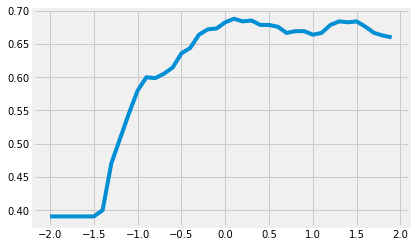

In [21]:
# FIND BEST ACCURACY WITH LINEAR CLASSIFIER

def acc(x):
    pca_preds = []
    for i in np.arange(len(pca_result)):
        if pca_result[i][0] >= x:
            pca_preds.append(1)
        else:
            pca_preds.append(0)
    
    accuracy = hamming_distance(pca_preds, y_train) / len(pca_preds)
    return accuracy

lines = []
accs = []
for i in np.arange(-2,2,0.1):
    lines.append(i)
    accs.append(acc(i))
    
plt.plot(lines, accs)
print('Best accuracy is', max(accs), 'at x =', lines[accs.index(max(accs))].round(1))